In [1]:
import pandas as pd
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric
import matplotlib.pyplot as plt
from tpr import aggregation_function
from WeatherData import aggregation_functionWeather
import os
import sys
from datetime import datetime
from calendar import day_abbr, month_abbr, mdays
from scipy.stats import skew
from sklearn.metrics import mean_absolute_error as MAE
from scipy.stats import skew
import seaborn as sns
import numpy as np
import utils

Importing plotly failed. Interactive plots will not work.


In [2]:
#Dataframe with Greek Holidays
holidays_dict = {'ds': ['2019-01-01',"2019-01-06", "2019-03-25", "2019-04-26",  "2019-04-29", "2019-05-01", "2019-06-17", "2019-08-15", "2019-10-28", "2019-12-25", "2019-12-26"], 'holiday' : ["New Year's Day", "Epiphany", "Independence Day", "Orthodox Good Friday", "Orthodox Easter Monday", "Labour Day", "Orthodox Whit Monday", "Assumption", "Ochi Day", "Christmas Day", "Boxing Day"] }
holidays_data = pd.DataFrame.from_dict(holidays_dict)

In [3]:
holidays_data

,ds,holiday
0,2019-01-01,New Year's Day
1,2019-01-06,Epiphany
2,2019-03-25,Independence Day
3,2019-04-26,Orthodox Good Friday
4,2019-04-29,Orthodox Easter Monday
5,2019-05-01,Labour Day
6,2019-06-17,Orthodox Whit Monday
7,2019-08-15,Assumption
8,2019-10-28,Ochi Day
9,2019-12-25,Christmas Day


In [4]:
#Aggregation function returns the data aggregated according to a value
data = aggregation_functionTomTom(60)
data

,timestamp,cs_Gate 10A - Entry,cs_Gate 10A - Exit,cs_Gate 16 - Entrance,cs_Gate 16 - Exit
0,2018-04-28 00:00:00,1.0,0.0,0.0,0.0
1,2018-04-28 01:00:00,0.0,0.0,0.0,0.0
2,2018-04-28 02:00:00,0.0,1.0,0.0,0.0
3,2018-04-28 03:00:00,0.0,0.0,0.0,0.0
4,2018-04-28 04:00:00,1.0,0.0,0.0,0.0
...,...,...,...,...,...
15547,2020-02-04 19:00:00,2.0,12.0,10.0,11.0
15548,2020-02-04 20:00:00,4.0,10.0,11.0,11.0
15549,2020-02-04 21:00:00,3.0,22.0,1.0,8.0
15550,2020-02-04 22:00:00,2.0,7.0,0.0,0.0


In [5]:
#We only work with one location at a time
i = 2
df = pd.DataFrame()
df['timestamp'] = pd.to_datetime(data['timestamp'], format = '%Y-%m-%d %H:%M:%S')
df['volume'] = data.iloc[:, i]
df

,timestamp,volume
0,2018-04-28 00:00:00,0.0
1,2018-04-28 01:00:00,0.0
2,2018-04-28 02:00:00,1.0
3,2018-04-28 03:00:00,0.0
4,2018-04-28 04:00:00,0.0
...,...,...
15547,2020-02-04 19:00:00,12.0
15548,2020-02-04 20:00:00,10.0
15549,2020-02-04 21:00:00,22.0
15550,2020-02-04 22:00:00,7.0


In [6]:
df = df.set_index('timestamp')

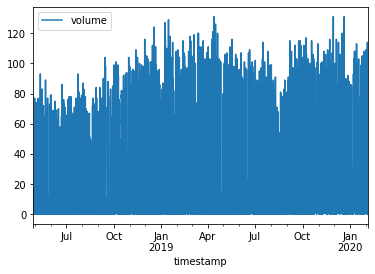

In [7]:
pd.plotting.register_matplotlib_converters()
df.plot()

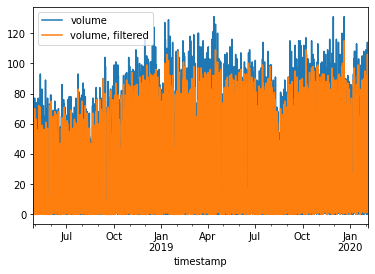

In [8]:
import utils
import scipy
from scipy.signal import medfilt
dfc = df.copy()
dfc.loc[:, 'volume, filtered'] = medfilt(dfc['volume'])
dfc.plot()


In [9]:
dfc.isnull().sum()

volume              0
volume, filtered    0
dtype: int64

In [10]:
df[df.isna().any(axis = 1)]

,volume
timestamp,


In [11]:
current_volume = dfc.loc[:,'volume, filtered'].rolling(window=50, center=True, min_periods=30).mean()
q25 = dfc.loc[:,'volume, filtered'].rolling(window=50, center=True, min_periods=30).quantile(0.25)
q75 = dfc.loc[:,'volume, filtered'].rolling(window=50, center=True, min_periods=30).quantile(0.75)

In [12]:
ndays_m = mdays.copy()
ndays_m[2] = 29

Text(0.5, 1.0, 'Volume')

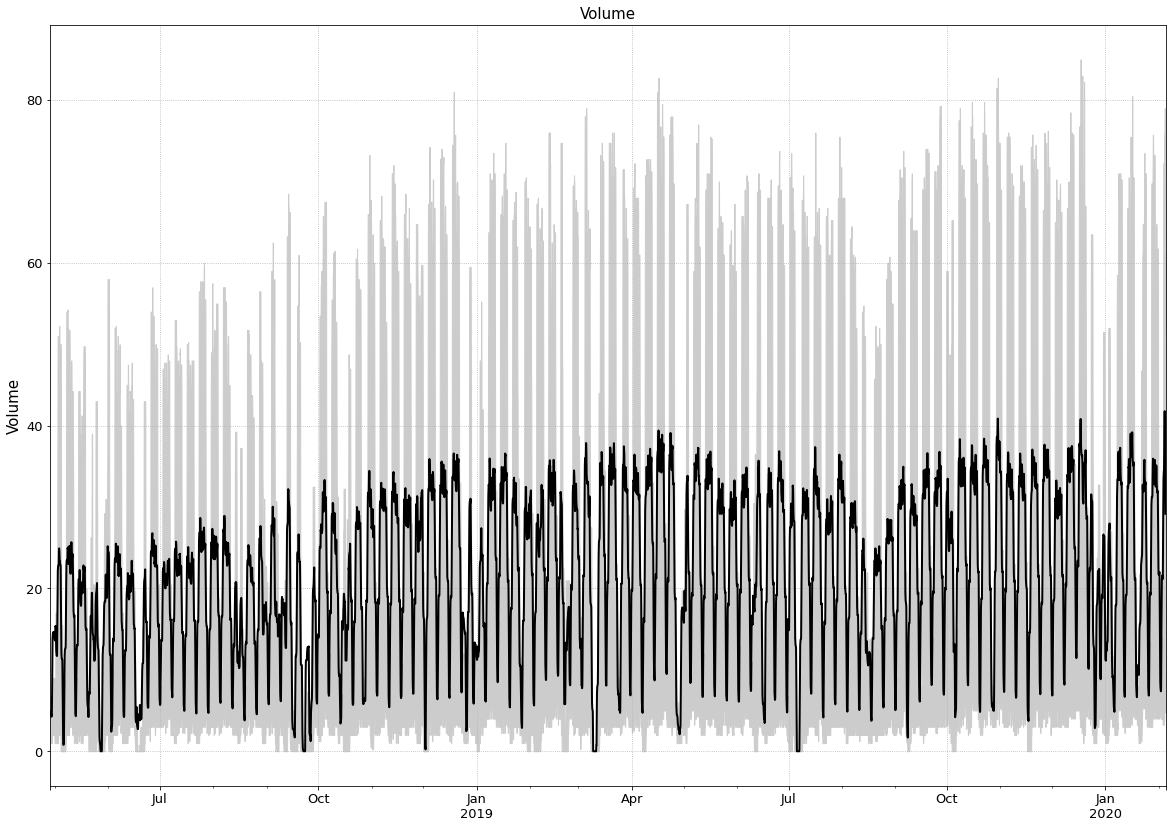

In [13]:
f, ax = plt.subplots(figsize=(20,14)) 

current_volume.plot(ax=ax, lw=2, color='k', legend=False)

ax.fill_between(current_volume.index, q25.values.ravel(), q75.values.ravel(), color='0.8')

#ax.set_xticks(ndays_m)
#ax.set_xticklabels(month_abbr)

ax.grid(ls=':')

ax.set_xlabel('', fontsize=15)

ax.set_ylabel('Volume', fontsize=15);

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_title('Volume', fontsize=15)

In [19]:
hour_week = dfc.loc[:, ['volume, filtered']].copy()
hour_week.loc[:, 'day_of_week'] = hour_week.index.dayofweek
hour_week.loc[:,'hour'] = hour_week.index.hour
hour_week = hour_week.groupby(['day_of_week', 'hour']).mean().unstack()
hour_week.columns = hour_week.columns.droplevel(0)

In [20]:
hour_week

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
day_of_week,,,,,,,,,,,,,,,,,,,,,
0,1.645161,1.387097,1.258065,1.193548,1.892473,2.795699,4.795699,25.827957,55.107527,62.548387,...,71.430108,61.989247,35.010753,25.935484,17.956989,11.806452,11.053763,9.741935,5.763441,2.602151
1,1.827957,1.290323,1.096774,0.978495,1.537634,2.182796,4.440860,22.322581,50.290323,59.978495,...,68.795699,59.021505,34.677419,25.741935,17.333333,11.774194,10.924731,9.569892,5.709677,2.559140
2,1.891304,1.358696,1.086957,0.978261,1.565217,2.423913,4.336957,22.260870,47.836957,57.130435,...,66.467391,56.097826,34.163043,24.456522,15.956522,11.913043,11.347826,9.902174,6.054348,2.858696
3,2.000000,1.554348,1.478261,1.239130,1.597826,2.467391,4.130435,22.684783,47.978261,57.173913,...,70.239130,61.684783,36.608696,26.521739,18.152174,12.684783,11.836957,10.934783,7.771739,3.402174
4,2.369565,1.836957,1.456522,1.108696,1.858696,2.760870,5.021739,23.239130,50.923913,58.478261,...,71.967391,64.326087,38.032609,29.880435,21.119565,15.630435,14.282609,12.586957,8.739130,4.271739
5,3.086022,2.387097,1.806452,1.505376,1.817204,1.935484,3.666667,8.913978,12.806452,14.322581,...,18.268817,12.118280,6.376344,4.946237,4.268817,4.344086,5.129032,5.860215,5.161290,2.731183
6,1.967742,1.881720,1.709677,1.419355,1.741935,1.903226,3.838710,4.290323,5.204301,4.924731,...,7.473118,5.870968,4.139785,3.408602,3.752688,4.053763,4.784946,4.967742,4.268817,2.225806


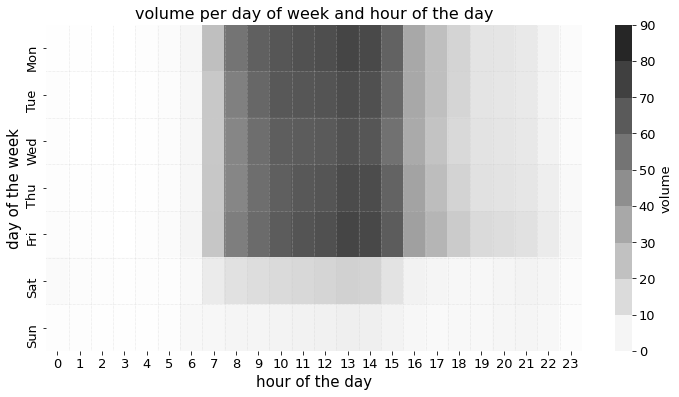

In [21]:
f, ax = plt.subplots(figsize=(12,6))

sns.heatmap(hour_week, ax = ax, cmap=plt.cm.gray_r, vmax=100, cbar_kws={'boundaries':np.arange(0,100,10)})
cbax = f.axes[1]
[l.set_fontsize(13) for l in cbax.yaxis.get_ticklabels()]
cbax.set_ylabel('volume', fontsize=13)

[ax.axhline(x, ls=':', lw=0.5, color='0.8') for x in np.arange(1, 7)]
[ax.axvline(x, ls=':', lw=0.5, color='0.8') for x in np.arange(1, 24)];

ax.set_title('volume per day of week and hour of the day', fontsize=16)

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_xlabel('hour of the day', fontsize=15)
ax.set_ylabel('day of the week', fontsize=15)
ax.set_yticklabels(day_abbr[0:7]);

In [22]:
weekdays = dfc.loc[dfc.index.strftime('%A').isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']), 'volume, filtered']
weekends = dfc.loc[dfc.index.strftime('%A').isin(['Saturda', 'Sunday']), 'volume, filtered']
summary_hour_weekdays = weekdays.groupby(weekdays.index.hour).describe()
summary_hour_weekends = weekends.groupby(weekends.index.hour).describe()

Text(0.5, 1.0, 'current volume per hour of the day')

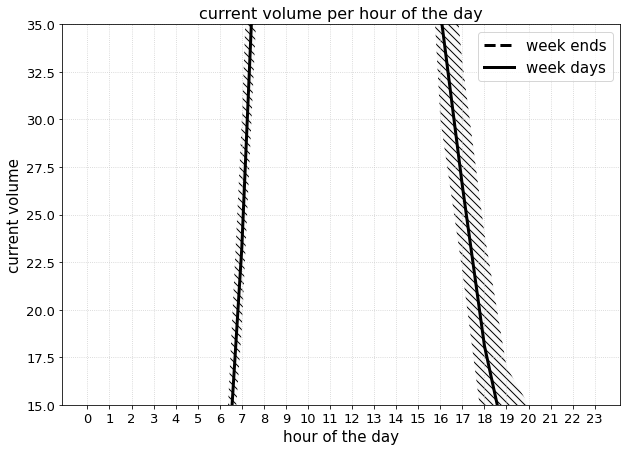

In [23]:
f, ax = plt.subplots(figsize = (10,7))
ax.plot(summary_hour_weekends.index, summary_hour_weekends.loc[:,'mean'], color='k', label='week ends', ls='--', lw=3)

ax.fill_between(summary_hour_weekends.index, summary_hour_weekends.loc[:,'25%'], \
                summary_hour_weekends.loc[:,'75%'], hatch='|||||', facecolor='0.8', alpha=0.1)

ax.set_xticks(range(24));

ax.grid(ls=':', color='0.8')

ax.plot(summary_hour_weekdays.index, summary_hour_weekdays.loc[:,'mean'], color='k', label='week days', lw=3)

ax.fill_between(summary_hour_weekdays.index, summary_hour_weekdays.loc[:,'25%'], \
                summary_hour_weekdays.loc[:,'75%'], hatch='\\\\\\', facecolor='0.8', alpha=0.1)

ax.legend(loc=1 , fontsize=15)

ax.set_xticks(range(24));

ax.grid(ls=':', color='0.8')

ax.set_ylim([15, 35])

ax.set_xlabel('hour of the day', fontsize=15)

ax.set_ylabel('current volume', fontsize=15);

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_title('current volume per hour of the day', fontsize=16)

In [24]:
data = dfc.loc[:, ['volume, filtered']].resample('60Min').mean()
data

,"volume, filtered"
timestamp,
2018-04-28 00:00:00,0.0
2018-04-28 01:00:00,0.0
2018-04-28 02:00:00,0.0
2018-04-28 03:00:00,0.0
2018-04-28 04:00:00,0.0
...,...
2020-02-04 19:00:00,12.0
2020-02-04 20:00:00,12.0
2020-02-04 21:00:00,10.0


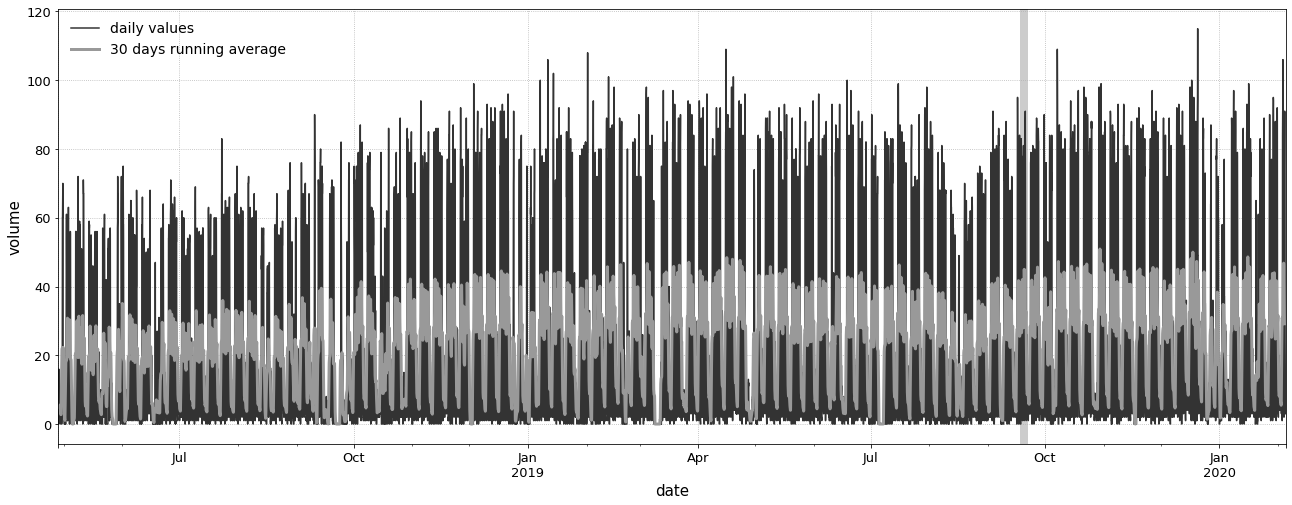

In [25]:
f, ax = plt.subplots(figsize=(22,8))
data.plot(ax=ax, color = '0.2')
data.rolling(window = 30, center = True).mean().plot(ax=ax, ls = '-', lw = 3, color = '0.6')
ax.grid(ls=':')
ax.legend(['daily values','30 days running average'], frameon=False, fontsize=14)
[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_xlabel('date', fontsize=15)

ax.set_ylabel('volume', fontsize=15);

ax.axvline('20/09/2019', color='0.8', lw=8, zorder=-1)

In [26]:
data_train = data[data.index <'2019-09-20']
data_train = data_train.reset_index()
data_train = data_train.rename({'volume, filtered' : 'y', 'timestamp' : 'ds'}, axis = 1)
data_train

,ds,y
0,2018-04-28 00:00:00,0.0
1,2018-04-28 01:00:00,0.0
2,2018-04-28 02:00:00,0.0
3,2018-04-28 03:00:00,0.0
4,2018-04-28 04:00:00,0.0
...,...,...
12235,2019-09-19 19:00:00,22.0
12236,2019-09-19 20:00:00,22.0
12237,2019-09-19 21:00:00,16.0
12238,2019-09-19 22:00:00,16.0


In [27]:
data_test = data[data.index > '2019-09-20']
data_test = data_test.reset_index()
data_test = data_test.rename({'volume, filtered' : 'y', 'timestamp' : 'ds'}, axis = 1)
data_test

,ds,y
0,2019-09-20 01:00:00,1.0
1,2019-09-20 02:00:00,2.0
2,2019-09-20 03:00:00,2.0
3,2019-09-20 04:00:00,2.0
4,2019-09-20 05:00:00,2.0
...,...,...
3306,2020-02-04 19:00:00,12.0
3307,2020-02-04 20:00:00,12.0
3308,2020-02-04 21:00:00,10.0
3309,2020-02-04 22:00:00,7.0


In [28]:
m = Prophet(mcmc_samples=300, holidays=holidays_data, holidays_prior_scale=0.25, changepoint_prior_scale=0.01, seasonality_mode='multiplicative', weekly_seasonality=True, daily_seasonality=True)

In [24]:
m.fit(data_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [25]:
future = m.make_future_dataframe(periods=len(data_test), freq='1H')

Exception: Model has not been fit.

In [26]:
future.head()

NameError: name 'future' is not defined

In [27]:
future.tail()

,ds
15546,2020-02-04 18:00:00
15547,2020-02-04 19:00:00
15548,2020-02-04 20:00:00
15549,2020-02-04 21:00:00
15550,2020-02-04 22:00:00


In [28]:
forecast = m.predict(future)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Assumption,Assumption_lower,Assumption_upper,Boxing Day,...,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2018-04-28 00:00:00,15.101831,-17.419814,20.127989,14.679932,15.561116,0.0,0.0,0.0,0.0,...,-0.962908,-0.991893,-0.933530,-0.007803,-0.027633,0.010899,0.0,0.0,0.0,0.560164
1,2018-04-28 01:00:00,15.102760,-17.815659,20.695316,14.681107,15.561996,0.0,0.0,0.0,0.0,...,-0.945672,-0.972477,-0.918382,-0.051969,-0.070928,-0.033308,0.0,0.0,0.0,0.820507
2,2018-04-28 02:00:00,15.103688,-17.577634,19.927854,14.682282,15.562875,0.0,0.0,0.0,0.0,...,-0.939740,-0.966393,-0.913601,-0.098182,-0.116885,-0.079499,0.0,0.0,0.0,0.910153
3,2018-04-28 03:00:00,15.104617,-18.954599,17.304219,14.683458,15.563716,0.0,0.0,0.0,0.0,...,-1.047261,-1.076015,-1.018031,-0.146221,-0.165087,-0.127922,0.0,0.0,0.0,-0.713863
4,2018-04-28 04:00:00,15.105546,-22.100100,15.699863,14.684633,15.564357,0.0,0.0,0.0,0.0,...,-1.208151,-1.238764,-1.176417,-0.195841,-0.214089,-0.177132,0.0,0.0,0.0,-3.144232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15546,2020-02-04 18:00:00,20.308678,-3.177875,35.559430,18.344532,22.296823,0.0,0.0,0.0,0.0,...,-0.242198,-0.270863,-0.212889,0.202487,0.183018,0.222759,0.0,0.0,0.0,15.389956
15547,2020-02-04 19:00:00,20.308066,-5.870288,32.008809,18.343166,22.296960,0.0,0.0,0.0,0.0,...,-0.323277,-0.352912,-0.294373,0.196977,0.177136,0.217249,0.0,0.0,0.0,13.742930
15548,2020-02-04 20:00:00,20.307455,-4.227533,33.640191,18.341800,22.297097,0.0,0.0,0.0,0.0,...,-0.300865,-0.328831,-0.273534,0.192715,0.173336,0.212617,0.0,0.0,0.0,14.197644
15549,2020-02-04 21:00:00,20.306843,-7.916545,32.877438,18.340434,22.297229,0.0,0.0,0.0,0.0,...,-0.356720,-0.384799,-0.329309,0.189679,0.170590,0.209757,0.0,0.0,0.0,13.062995


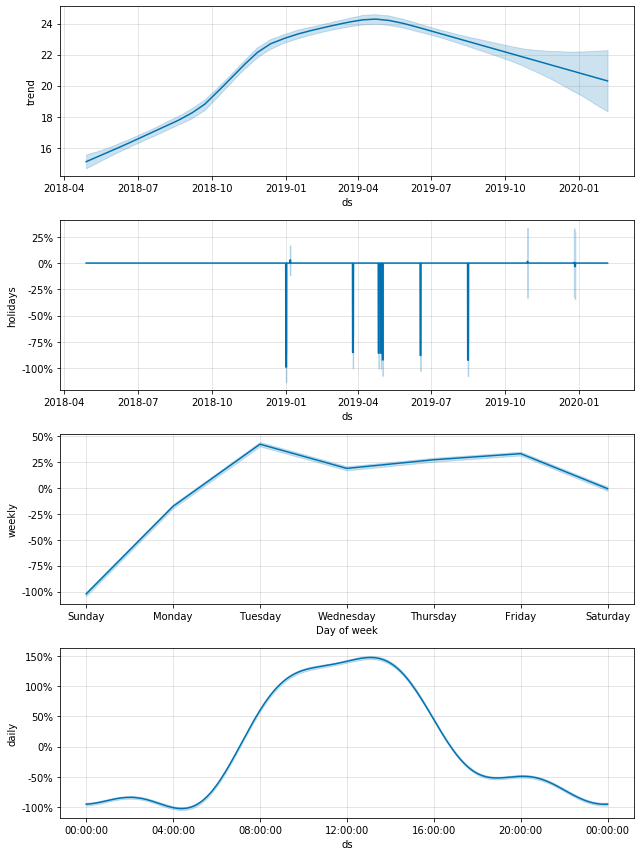

In [29]:
f = m.plot_components(forecast)

In [30]:
verif = utils.make_verif(forecast, data_train, data_test)

In [31]:
verif

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Assumption,Assumption_lower,Assumption_upper,Boxing Day,...,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,y
ds,,,,,,,,,,,,,,,,,,,,,
2018-04-28 00:00:00,2018-04-28 00:00:00,15.101831,-17.419814,20.127989,14.679932,15.561116,0.0,0.0,0.0,0.0,...,-0.991893,-0.933530,-0.007803,-0.027633,0.010899,0.0,0.0,0.0,0.560164,0.0
2018-04-28 01:00:00,2018-04-28 01:00:00,15.102760,-17.815659,20.695316,14.681107,15.561996,0.0,0.0,0.0,0.0,...,-0.972477,-0.918382,-0.051969,-0.070928,-0.033308,0.0,0.0,0.0,0.820507,0.0
2018-04-28 02:00:00,2018-04-28 02:00:00,15.103688,-17.577634,19.927854,14.682282,15.562875,0.0,0.0,0.0,0.0,...,-0.966393,-0.913601,-0.098182,-0.116885,-0.079499,0.0,0.0,0.0,0.910153,0.0
2018-04-28 03:00:00,2018-04-28 03:00:00,15.104617,-18.954599,17.304219,14.683458,15.563716,0.0,0.0,0.0,0.0,...,-1.076015,-1.018031,-0.146221,-0.165087,-0.127922,0.0,0.0,0.0,-0.713863,0.0
2018-04-28 04:00:00,2018-04-28 04:00:00,15.105546,-22.100100,15.699863,14.684633,15.564357,0.0,0.0,0.0,0.0,...,-1.238764,-1.176417,-0.195841,-0.214089,-0.177132,0.0,0.0,0.0,-3.144232,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-04 18:00:00,2020-02-04 18:00:00,20.308678,-3.177875,35.559430,18.344532,22.296823,0.0,0.0,0.0,0.0,...,-0.270863,-0.212889,0.202487,0.183018,0.222759,0.0,0.0,0.0,15.389956,18.0
2020-02-04 19:00:00,2020-02-04 19:00:00,20.308066,-5.870288,32.008809,18.343166,22.296960,0.0,0.0,0.0,0.0,...,-0.352912,-0.294373,0.196977,0.177136,0.217249,0.0,0.0,0.0,13.742930,12.0
2020-02-04 20:00:00,2020-02-04 20:00:00,20.307455,-4.227533,33.640191,18.341800,22.297097,0.0,0.0,0.0,0.0,...,-0.328831,-0.273534,0.192715,0.173336,0.212617,0.0,0.0,0.0,14.197644,12.0


# Train Set

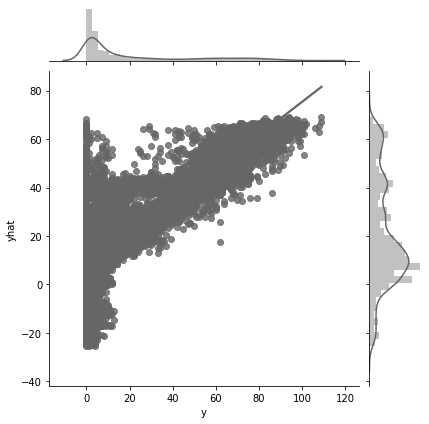

In [32]:
sns.jointplot('y', 'yhat',data = verif.loc[:'2019-09-20', :], kind = 'reg', color = '0.4')

In [33]:
verif = verif.dropna(subset = ['y'])
verif[pd.isnull(verif.y)]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Assumption,Assumption_lower,Assumption_upper,Boxing Day,...,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,y
ds,,,,,,,,,,,,,,,,,,,,,


In [34]:
verif.loc[:'2019-09-20', ['y', 'yhat']].corr()

,y,yhat
y,1.000000,0.832167
yhat,0.832167,1.000000


In [35]:
MAE(verif.loc[:'2019-09-20', 'y'].values, verif.loc[:'2019-09-20', 'yhat'].values)

11.204517842896133

# Test Set

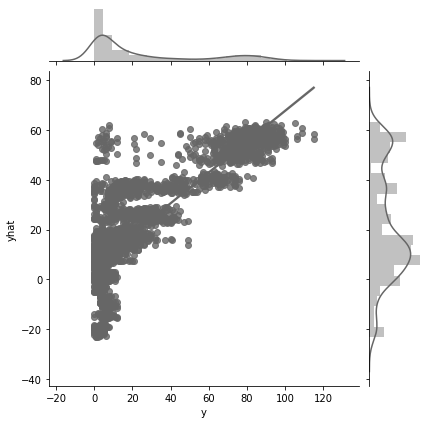

In [36]:
sns.jointplot('y', 'yhat',data = verif.loc['2019-09-20':, :], kind = 'reg', color = '0.4')


In [37]:
verif.loc['2019-09-20':, ['y', 'yhat']].corr()

,y,yhat
y,1.000000,0.843685
yhat,0.843685,1.000000


In [38]:
MAE(verif.loc['2019-09-20':, 'y'].values, verif.loc['2019-09-20':, 'yhat'].values)

12.735193020829511

Text(0, 0.5, 'NORMALIZED FREQUENCY')

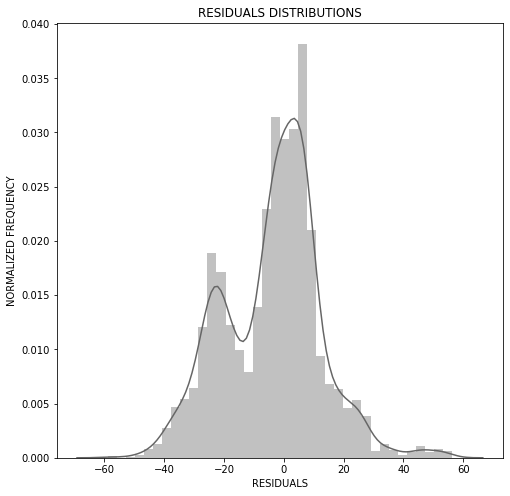

In [39]:
f, ax = plt.subplots(figsize = (8,8))
sns.distplot((verif.loc['2019-09-20':, 'yhat'] - verif.loc['2019-09-20': , 'y']), color = '0.4')
ax.set_title("RESIDUALS DISTRIBUTIONS")
ax.set_xlabel("RESIDUALS")
ax.set_ylabel("NORMALIZED FREQUENCY")

In [40]:
skew(verif.loc['2019-09-20':, 'y'].values - verif.loc['2019-09-20':, 'yhat'].values)

-0.034051596990816634

In [41]:
residuals = (verif.loc['2019-09-20':, 'y']- verif.loc['2019-09-20':, 'yhat'])

In [42]:
residuals.median()

1.6643336360811123

In [43]:
residuals.mean()

3.7351500379500244

In [2]:
from TrafficData import aggregation_functionTraffic
traffic_data = aggregation_functionTraffic(60)

In [3]:
traffic_data

,Avg_Speed
Timestamp,
2018-04-27 00:00:00,46.883333
2018-04-27 01:00:00,49.800000
2018-04-27 02:00:00,48.100000
2018-04-27 03:00:00,44.125000
2018-04-27 04:00:00,52.116667
...,...
2020-02-05 17:00:00,50.933333
2020-02-05 18:00:00,49.033333
2020-02-05 19:00:00,50.283333


In [4]:
traffic_data = traffic_data.loc[:, ['Avg_Speed']]
traffic_data

,Avg_Speed
Timestamp,
2018-04-27 00:00:00,46.883333
2018-04-27 01:00:00,49.800000
2018-04-27 02:00:00,48.100000
2018-04-27 03:00:00,44.125000
2018-04-27 04:00:00,52.116667
...,...
2020-02-05 17:00:00,50.933333
2020-02-05 18:00:00,49.033333
2020-02-05 19:00:00,50.283333


In [5]:
traffic_data.corr()

,Avg_Speed
Avg_Speed,1.0


In [29]:
data_all = (data.reset_index()).merge(traffic_data, left_on = "timestamp", right_on = "Timestamp")
data_all.rename

data_all.set_index('timestamp', inplace = True)

In [30]:
data_all.corr()

,"volume, filtered",Avg_Speed
"volume, filtered",1.000000,-0.192324
Avg_Speed,-0.192324,1.000000


In [31]:
data_all['Avg_Speed'] = data_all['Avg_Speed'].interpolate(method = 'linear')

In [32]:
data_all

,"volume, filtered",Avg_Speed
timestamp,,
2018-04-28 00:00:00,0.0,48.300000
2018-04-28 01:00:00,0.0,50.833333
2018-04-28 02:00:00,0.0,48.266667
2018-04-28 03:00:00,0.0,44.900000
2018-04-28 04:00:00,0.0,49.200000
...,...,...
2020-02-04 19:00:00,12.0,44.533333
2020-02-04 20:00:00,12.0,54.000000
2020-02-04 21:00:00,10.0,55.216667


In [33]:
data_train_all = data_all[data_all.index < '2019-09-20']
data_train_all = data_train_all.reset_index()
data_train_all = data_train_all.rename({'volume, filtered' : 'y', 'timestamp' : 'ds'}, axis = 1)
data_train_all.tail()

,ds,y,Avg_Speed
12235,2019-09-19 19:00:00,22.0,40.95
12236,2019-09-19 20:00:00,22.0,43.20
12237,2019-09-19 21:00:00,16.0,44.15
12238,2019-09-19 22:00:00,16.0,36.95
12239,2019-09-19 23:00:00,6.0,44.15


In [34]:
data_test_all = data_all[data_all.index >= '2019-09-20']
data_test_all = data_test_all.reset_index()
data_test_all = data_test_all.rename({'volume, filtered' : 'y', 'timestamp' : 'ds'}, axis = 1)
data_test_all.tail()

,ds,y,Avg_Speed
3307,2020-02-04 19:00:00,12.0,44.533333
3308,2020-02-04 20:00:00,12.0,54.000000
3309,2020-02-04 21:00:00,10.0,55.216667
3310,2020-02-04 22:00:00,7.0,52.216667
3311,2020-02-04 23:00:00,3.0,50.950000


In [35]:
m = Prophet(mcmc_samples=300, holidays=holidays_data, holidays_prior_scale=0.25, changepoint_prior_scale=0.01, seasonality_mode='multiplicative', weekly_seasonality=True, daily_seasonality=True)

In [36]:
m.add_regressor('Avg_Speed', prior_scale = 0.5, mode = 'additive')

In [37]:
m.fit(data_train_all)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [38]:
future = m.make_future_dataframe(periods = len(data_test_all), freq = '1H')

In [39]:
future.head()

,ds
0,2018-04-28 00:00:00
1,2018-04-28 01:00:00
2,2018-04-28 02:00:00
3,2018-04-28 03:00:00
4,2018-04-28 04:00:00


In [40]:
future.tail()

,ds
15547,2020-02-04 19:00:00
15548,2020-02-04 20:00:00
15549,2020-02-04 21:00:00
15550,2020-02-04 22:00:00
15551,2020-02-04 23:00:00


In [41]:
futures = (future).merge(data_all[['Avg_Speed']], left_on = "ds", right_on = "timestamp")

In [42]:
forecast = m.predict(futures)

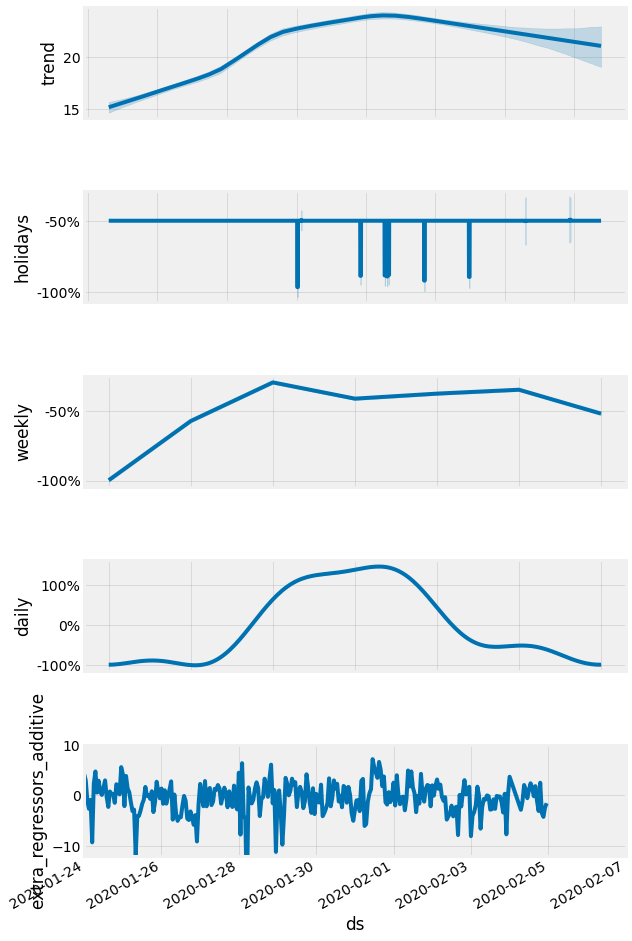

In [70]:
f = m.plot_components(forecast)
#Applying styles to the plots
plt.style.use('fivethirtyeight')
plt.axis([pd.to_datetime("2020-1-24", format = '%Y-%m-%d'),pd.to_datetime("2020-2-7", format = '%Y-%m-%d'),-12,10])
plt.gcf().autofmt_xdate()

In [44]:
verif = utils.make_verif(forecast, data_train_all, data_test_all)

In [45]:
verif.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Assumption,Assumption_lower,Assumption_upper,Avg_Speed,...,holidays_lower,holidays_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yhat,y
ds,,,,,,,,,,,,,,,,,,,,,
2018-04-28 00:00:00,2018-04-28 00:00:00,15.190412,-17.426938,19.044489,14.666576,15.696970,0.0,0.0,0.0,0.116608,...,0.0,0.0,-1.017989,-1.047538,-0.988609,-0.033348,-0.052352,-0.015565,-0.156650,0.0
2018-04-28 01:00:00,2018-04-28 01:00:00,15.191368,-19.112893,17.705686,14.667874,15.697742,0.0,0.0,0.0,-1.490563,...,0.0,0.0,-1.010067,-1.039638,-0.980488,-0.076753,-0.095655,-0.058984,-1.643488,0.0
2018-04-28 02:00:00,2018-04-28 02:00:00,15.192324,-18.247871,18.571933,14.669174,15.698513,0.0,0.0,0.0,0.137755,...,0.0,0.0,-1.001129,-1.028462,-0.972894,-0.122043,-0.139824,-0.104725,0.120607,0.0
2018-04-28 03:00:00,2018-04-28 03:00:00,15.193280,-18.425162,18.372370,14.670474,15.699284,0.0,0.0,0.0,2.273601,...,0.0,0.0,-1.087341,-1.117477,-1.056468,-0.168996,-0.186405,-0.152574,0.946600,0.0
2018-04-28 04:00:00,2018-04-28 04:00:00,15.194235,-21.753641,15.223900,14.671774,15.700055,0.0,0.0,0.0,-0.454360,...,0.0,0.0,-1.211625,-1.243175,-1.180104,-0.217364,-0.234419,-0.201222,-3.669842,0.0


# Train Set

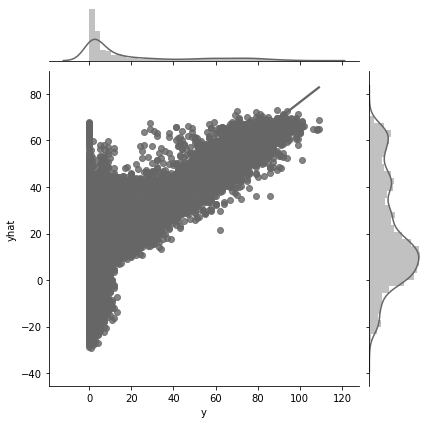

In [46]:
sns.jointplot('y', 'yhat', data = verif.loc[:'2019-09-20', :], kind = 'reg', color = '0.4')

In [47]:
verif = verif.dropna(subset = ['y'])
verif[pd.isnull(verif.y)]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Assumption,Assumption_lower,Assumption_upper,Avg_Speed,...,holidays_lower,holidays_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yhat,y
ds,,,,,,,,,,,,,,,,,,,,,


In [48]:
verif.loc[:'2019-09-20', ['y', 'yhat']].corr()

,y,yhat
y,1.000000,0.840023
yhat,0.840023,1.000000


In [49]:
MAE(verif.loc[:'2019-09-20', 'y'].values, verif.loc[:'2019-09-20', 'yhat'].values)

10.970138380348722

In [50]:
MAE(verif.loc[:'2019-09-20', 'y'].values, verif.loc[:'2019-09-20', 'yhat'].values)

10.970138380348722

In [51]:
def mape_vectorized_v2(a, b): 
    mask = a != 0
    return (np.fabs(a - b)/a)[mask].mean()

In [52]:
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_squared_log_error as MSLE

In [53]:
MAE(verif.loc[:'2019-09-20', 'y'].values, verif.loc[:'2019-09-20', 'yhat'].values)

10.970138380348722

In [54]:
MSE(verif.loc[:'2019-09-20', 'y'].values, verif.loc[:'2019-09-20', 'yhat'].values)

210.96332046744158

In [ ]:
mape_vectorized

In [55]:
mape_vectorized_v2(verif.loc[:'2019-09-20', 'y'].values, verif.loc[:'2019-09-20', 'yhat'].values)bb

C:\Users\Nacho\miniconda3\envs\stan_env\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


2.1675811509514062

In [56]:
MSLE(verif.loc[:'2019-09-20', 'y'].values, verif.loc[:'2019-09-20', 'yhat'].values)

ValueError: Mean Squared Logarithmic Error cannot be used when targets contain negative values.

# Test Set

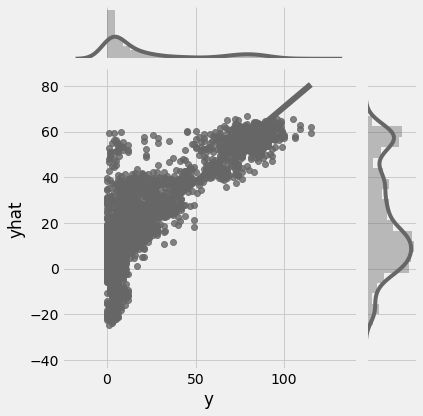

In [71]:
sns.jointplot('y', 'yhat',data = verif.loc['2019-09-20':, :], kind = 'reg', color = '0.4')

In [72]:
verif.loc['2019-09-20':, ['y', 'yhat']].corr()

,y,yhat
y,1.000000,0.858281
yhat,0.858281,1.000000


In [73]:
MAE(verif.loc['2019-09-20':, 'y'].values, verif.loc['2019-09-20':, 'yhat'].values)

12.160556775885125

Text(0, 0.5, 'NORMALIZED FREQUENCY')

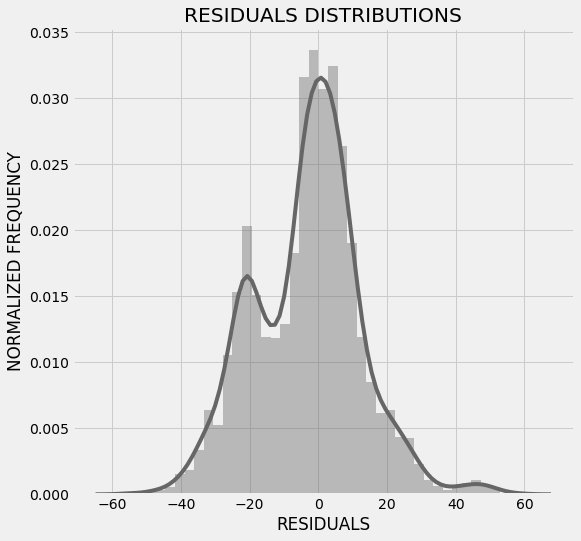

In [74]:
f, ax = plt.subplots(figsize = (8,8))
sns.distplot((verif.loc['2019-09-20':, 'yhat'] - verif.loc['2019-09-20': , 'y']), color = '0.4')
ax.set_title("RESIDUALS DISTRIBUTIONS")
ax.set_xlabel("RESIDUALS")
ax.set_ylabel("NORMALIZED FREQUENCY")

In [75]:
skew(verif.loc['2019-09-20':, 'y'].values - verif.loc['2019-09-20':, 'yhat'].values)

-0.09358897659437103

In [77]:
residuals = (verif.loc['2019-09-20':, 'y']- verif.loc['2019-09-20':, 'yhat'])

In [78]:
residuals.median()

1.6783140047687

In [79]:
residuals.mean()

3.2575508432225635

In [81]:
MSE(verif.loc['2019-09-20':, 'y'].values, verif.loc['2019-09-20':, 'yhat'].values)

253.35094683384645

In [82]:
MSLE(verif.loc['2019-09-20':, 'y'].values, verif.loc['2019-09-20':, 'yhat'].values)

ValueError: Mean Squared Logarithmic Error cannot be used when targets contain negative values.

In [84]:
mape_vectorized_v2(verif.loc['2019-09-20':, 'y'].values, verif.loc['2019-09-20':, 'yhat'].values)

C:\Users\Nacho\miniconda3\envs\stan_env\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


1.845201950844281

In [80]:
verif

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Assumption,Assumption_lower,Assumption_upper,Avg_Speed,...,holidays_lower,holidays_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yhat,y
ds,,,,,,,,,,,,,,,,,,,,,
2018-04-28 00:00:00,2018-04-28 00:00:00,15.190412,-17.426938,19.044489,14.666576,15.696970,0.0,0.0,0.0,0.116608,...,0.0,0.0,-1.017989,-1.047538,-0.988609,-0.033348,-0.052352,-0.015565,-0.156650,0.0
2018-04-28 01:00:00,2018-04-28 01:00:00,15.191368,-19.112893,17.705686,14.667874,15.697742,0.0,0.0,0.0,-1.490563,...,0.0,0.0,-1.010067,-1.039638,-0.980488,-0.076753,-0.095655,-0.058984,-1.643488,0.0
2018-04-28 02:00:00,2018-04-28 02:00:00,15.192324,-18.247871,18.571933,14.669174,15.698513,0.0,0.0,0.0,0.137755,...,0.0,0.0,-1.001129,-1.028462,-0.972894,-0.122043,-0.139824,-0.104725,0.120607,0.0
2018-04-28 03:00:00,2018-04-28 03:00:00,15.193280,-18.425162,18.372370,14.670474,15.699284,0.0,0.0,0.0,2.273601,...,0.0,0.0,-1.087341,-1.117477,-1.056468,-0.168996,-0.186405,-0.152574,0.946600,0.0
2018-04-28 04:00:00,2018-04-28 04:00:00,15.194235,-21.753641,15.223900,14.671774,15.700055,0.0,0.0,0.0,-0.454360,...,0.0,0.0,-1.211625,-1.243175,-1.180104,-0.217364,-0.234419,-0.201222,-3.669842,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-04 19:00:00,2020-02-04 19:00:00,21.101063,-2.991272,34.305124,19.082639,22.984233,0.0,0.0,0.0,2.506218,...,0.0,0.0,-0.343878,-0.372263,-0.313182,0.193061,0.172902,0.213965,16.351082,12.0
2020-02-04 20:00:00,2020-02-04 20:00:00,21.100601,-9.422048,30.210255,19.081536,22.984381,0.0,0.0,0.0,-3.499527,...,0.0,0.0,-0.316964,-0.348091,-0.284794,0.188793,0.168258,0.209582,10.912940,12.0
2020-02-04 21:00:00,2020-02-04 21:00:00,21.100139,-9.753829,26.773589,19.080433,22.984529,0.0,0.0,0.0,-4.271392,...,0.0,0.0,-0.368695,-0.401052,-0.336007,0.185709,0.164989,0.207021,9.049225,10.0


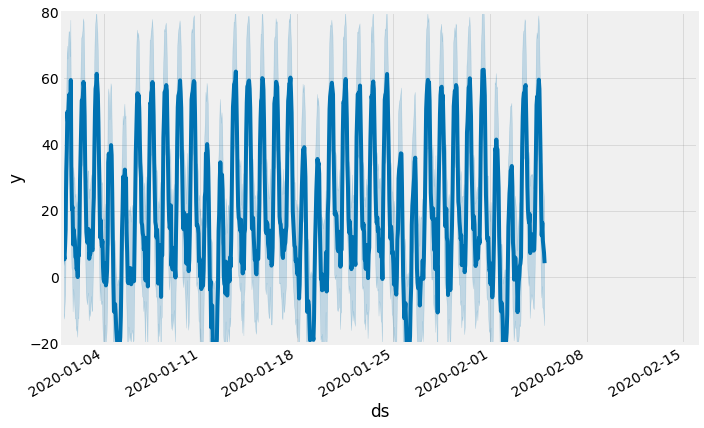

In [59]:
m.plot(forecast)
#Applying styles to the plots
plt.style.use('fivethirtyeight')
plt.axis([pd.to_datetime("2020-1-1", format = '%Y-%m-%d'),pd.to_datetime("2020-02-16", format = '%Y-%m-%d'),-20,80])
plt.gcf().autofmt_xdate()

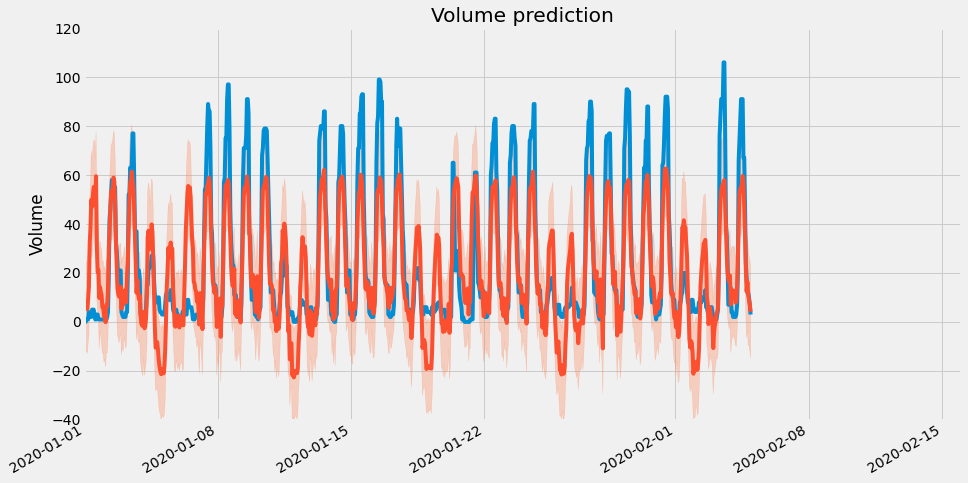

In [62]:
fig, ax = plt.subplots(figsize = (14,8))
ax.plot(verif.index, verif['y'], label = 'True values')
ax.plot(verif.index, verif['yhat'], label = 'Predicted values')
ax.set_title("Volume prediction")
ax.fill_between(verif.index, verif.loc[:, 'yhat_lower'], verif.loc[:, 'yhat_upper'], color = 'coral', alpha = 0.3)
plt.ylabel("Volume")
#Applying styles to the plots
plt.style.use('fivethirtyeight')
plt.axis([pd.to_datetime("2020-1-1", format = '%Y-%m-%d'),pd.to_datetime("2020-02-16", format = '%Y-%m-%d'),-40,120])
plt.gcf().autofmt_xdate()


# Correlaciones diarias

In [81]:
corr = verif.loc[:, ['y', 'yhat']].rolling(window = 1000).corr()

In [82]:
corr.index = corr.index.droplevel(1)

Text(0.5, 1.0, 'Correlaciones con media rodante de 1000 períodos')

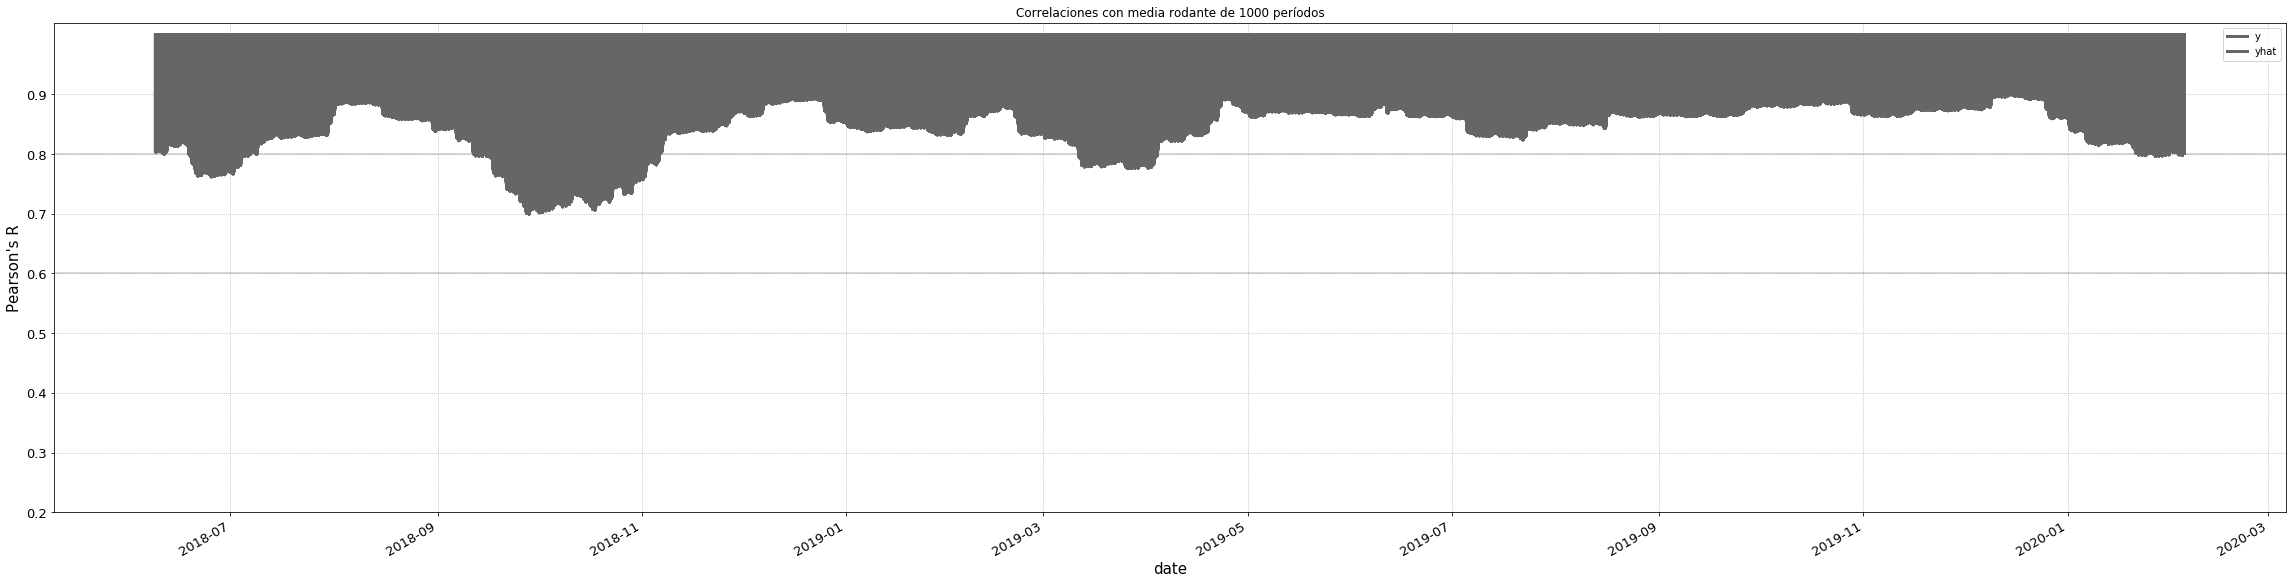

In [83]:
fig, ax = plt.subplots(figsize = (40,10))
corr.plot(ax=ax, lw = 3, color = '0.4')
ax.axhline(0.8, color='0.8', zorder=-1)
ax.axhline(0.6, color='0.8', zorder=-1)
ax.grid(ls=':')
ax.set_xlabel('date', fontsize=15)
ax.set_ylabel("Pearson's R", fontsize=15)
ax.grid(ls=':')
[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_yticks(np.arange(0.2, 1., 0.1)); 
ax.set_title('Correlaciones con media rodante de 1000 períodos')


Mucha variabilidad en los datos a lo largo del día, con mucho porcentaje aleatorio que Prophet no es capaz de predecir. 

# Correlaciones por mes

In [84]:
corr_season_train = verif.loc[:'2019-09-20', ['y', 'yhat']].groupby(verif.loc[:'2019-09-20', :].index.month).corr()
corr_season_test = verif.loc['2019-09-20':, ['y', 'yhat']].groupby(verif.loc['2019-09-20':, :].index.month).corr()
corr_season = verif.loc[:,['y','yhat']].groupby(verif.loc[:,:].index.month).corr()

Text(0.5, 1.0, 'Correlation per month')

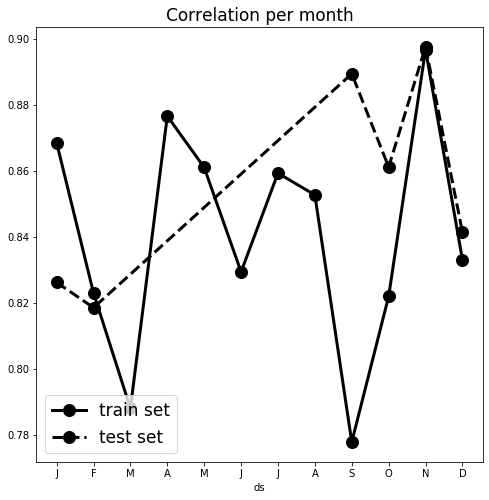

In [85]:
f, ax = plt.subplots(figsize=(8,8))
corr_season_train.xs('y', axis=0, level=1)['yhat'].plot(ax=ax, lw=3, marker='o', markersize=12, label='train set', ls='-', color='k')
corr_season_test.xs('y', axis=0, level=1)['yhat'].plot(ax=ax, lw=3, marker='o', markersize=12, label='test set', ls='--', color='k')
# corr_season.xs('y', axis=0, level=1)['yhat'].plot(ax=ax, lw=3, marker='o', markersize=12)

ax.legend(fontsize=17, loc=3)

ax.set_xticks(range(1, 13))
ax.set_xticklabels(list('JFMAMJJASOND'))
ax.set_title('Correlation per month', fontsize=17)